# Project Notebook

This Notebook is done as part of a project in the course "Machine Learning in Times Series" by Laurent OURDE and has been done by Stanislas DOZIAS and Meryem JAAIDAN.

## Imports

### WARNING: sktime version is 0.8.1

(in order to have MrSEQLClassifier: it has been removed from sktime later for compatibility purposes)

In [2]:
import string
import os

import numpy as np
from matplotlib import pyplot as plt

from sktime.classification.shapelet_based import MrSEQLClassifier # https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/mrseql.pyx
from sktime.datasets._data_io import load_from_tsfile_to_dataframe
from sktime.utils.validation.panel import check_X

### usefull links:

- sktime folder with MrSEQL algorithm: https://github.com/sktime/sktime/tree/v0.8.1/sktime/classification/shapelet_based/mrseql


- original github of the paper (in c++) https://github.com/lnthach/Mr-SEQL

### What we recoded and what we didn't

The goal of this notebook is to recode the specific things of the paper, in a realistic time. So we recoded (by inspiring us from some C++ code):
- The SAX representation
- The plot of the discriminative regions used for interpretation (there will be some difference in the results which we can't explain)

More precisely, we didn't recode the SEQL part and its training, letting this for the already implemented `MrSEQLClassifier`.

## Test on paper examples for SAX representation

### Constant parameters

In [3]:
alpha = 4
break_points = [-0.674489750196, 0.0, 0.674489750196]

### Only 1 windows

In [4]:
def segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order = False, normalize=True):
    """
    adaptation of this code https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/sax_converter.h

    Convert a part of a timeseries (from cur_pos to cur_pos + window_size) to its SAX representation, given a window_length 'l' and a word_length 'w'.

    If 'paper_alphabet_order' is True, it uses the order of the examples in the paper, i.e 'a' for high values
    If 'normalize' is False, it doesn't normalize the window before applying PPA
    """
    # the following variable renaming is to better match both implementations
    window_size = l
    word_length = w
    alphabet_size = alpha

    window_end = cur_pos + window_size

    mean_wd = np.mean(timeseries[cur_pos:window_end])
    var_wd = np.var(timeseries[cur_pos:window_end])

    subsection = np.zeros(window_size)
    for i in range(cur_pos, window_end):
        if normalize:
            normalized_value = timeseries[i]-mean_wd
            if var_wd>0:
                normalized_value = normalized_value / np.sqrt(var_wd)
        else:
            normalized_value = timeseries[i]
        subsection[i-cur_pos] = normalized_value
        
    paa_size = window_size / word_length
    sax_word = ""
    list_PPA = np.zeros(int(paa_size)*word_length) # added, to retrieve the PPA computed
    for i in range(word_length):
        bin = 0
        windowStartIdx = paa_size * i
        windowEndIdx = paa_size * (i + 1) - 1
        fullWindowStartIdx = int(np.ceil(windowStartIdx))
        fullWindowEndIdx = int(np.floor(windowEndIdx))
        startFraction = fullWindowStartIdx - windowStartIdx
        endFraction = windowEndIdx - fullWindowEndIdx

        aggValue = 0
        if (startFraction > 0):
            aggValue += subsection[fullWindowStartIdx - 1] * startFraction

        # 2nd condition is a safeguard against index-out-of-bounds because of
        # numerical imprecision
        if (endFraction > 0 and fullWindowEndIdx < window_size - 1) :
            aggValue += subsection[fullWindowEndIdx + 1] * endFraction
        for j in range(fullWindowStartIdx, fullWindowEndIdx+1):
            aggValue += subsection[j]
        PAA = aggValue / paa_size

        for k in range(int(paa_size)): # added, to retrieve the PPA computed
            list_PPA[int(paa_size)*i+k] = PAA

        for j in range(alphabet_size-1):
            if (PAA >= break_points[j]):
                bin += 1

        if paper_alphabet_order:
            sax_word += string.ascii_lowercase[alphabet_size - bin - 1] # this is to do like in the paper
        else:
            sax_word += string.ascii_lowercase[bin] # this is what is implemented

    return sax_word, list_PPA, subsection

In [5]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001])

l = timeseries.shape[0]
w = 4

As in the article: babc (i.e. not normalized and 'a' for high value)
As it is used in the code: cdba (i.e. normalized and 'a' for low value)


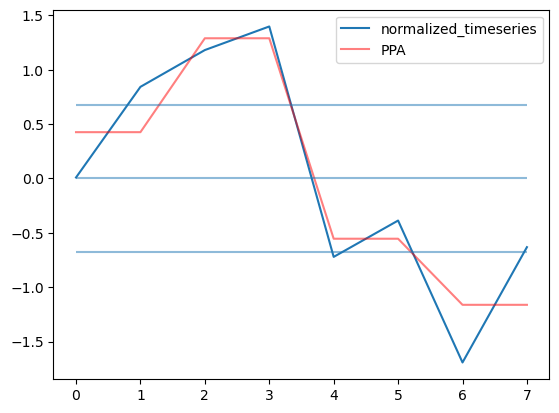

In [6]:
sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {sax_word} (i.e. not normalized and 'a' for high value)")

sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w)
print(f"As it is used in the code: {sax_word} (i.e. normalized and 'a' for low value)")

plt.plot(subsection, label="normalized_timeseries")
plt.plot(list_PPA, alpha=0.5, color="r", label = "PPA")
plt.hlines(break_points, 0, l-1, alpha=0.5)
plt.legend()
plt.show()

To compare with

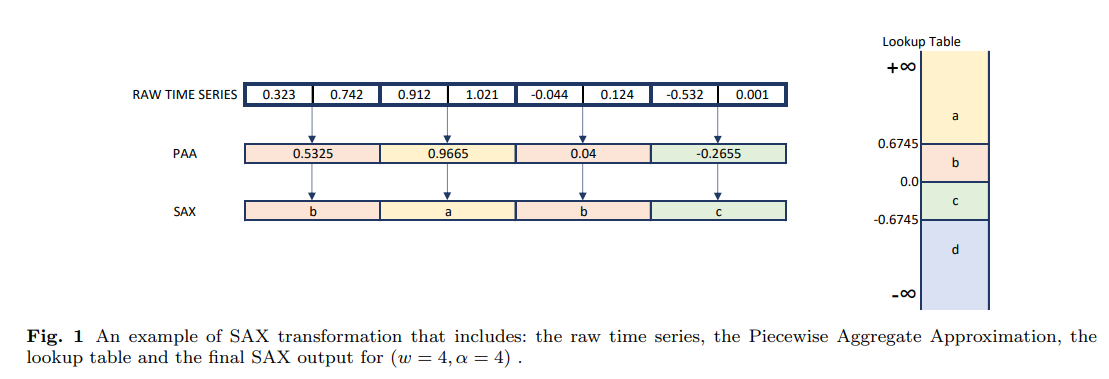

### Sliding windows

In [7]:
def timeseries2SAX(timeseries, l, w, paper_alphabet_order=False, normalize=True):
    """
    Convert a timeseries to its SAX representation, given a window_lenght 'l' and a word size 'w'.
    'paper_alphabet_order' and 'normalize' are the same parameters as in 'segment2SAX'
    """
    L = timeseries.shape[0]
    # PAA transform (and inverse transform) of the data
    list_word = []
    for cur_pos in range(L-l+1):
        sax_word, list_PPA, subsection = segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order, normalize)
        list_word.append(sax_word)
    return list_word

In [8]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001, -0.343, -1.211])

l = 8
w = 4

In [9]:
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {' '.join(list_word)} (i.e. not normalized and 'a' for high value)")

list_word = timeseries2SAX(timeseries, l, w)
print(f"As it is used in the code: {' '.join(list_word)} (i.e. normalized and 'a' for low value)")

As in the article: babc abcc abcd (i.e. not normalized and 'a' for high value)
As it is used in the code: cdba dcaa dcba (i.e. normalized and 'a' for low value)


To compare with

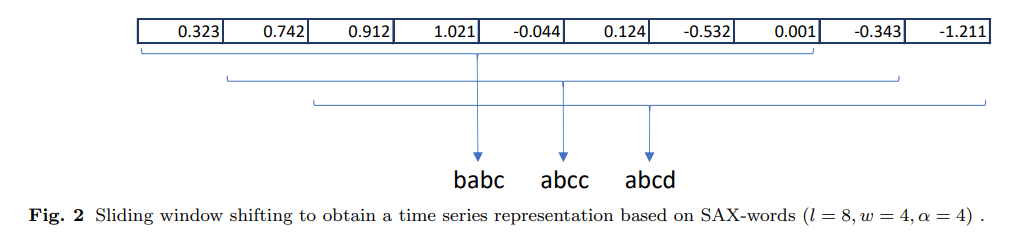

### Conclusion of these comparisons

The SAX examples are wrong because the normalization isn't done.

Furthermore, as we will see in the next part, the order for the sumbols are also inversed, with 'a' for low value (and not high values like in the paper example).

## GunPoint dataset

This is the same dataset as in the paper example, the goal here is to retrieve their results.

### Load data and show example

We need to download by hand the time series from https://timeseriesclassification.com/ and load them with the good path.

This is because we took the version 0.8.1 of sktime in order to have MR_SEQL algorithm.

In [11]:
DATA_PATH = os.path.join("./../data/Univariate_ts/")

dataset_name = "GunPoint"

class_dict = {"1": "Gun", "2": "Point"}

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TRAIN.ts")
)
X_test, y_test = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TEST.ts")
)

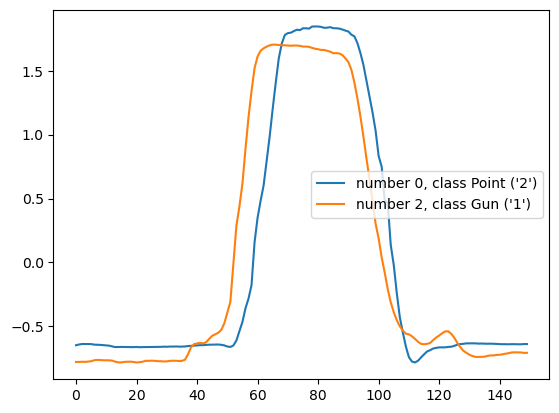

In [12]:
# An example of 2 Time Series from this dataset

i, j = 0, 2
plt.plot(X_train["dim_0"].iloc[i], label=f"number {i}, class {class_dict[y_train[i]]} ('{y_train[i]}')")
plt.plot(X_train["dim_0"].iloc[j], label=f"number {j}, class {class_dict[y_train[j]]} ('{y_train[j]}')")

plt.legend()
plt.show()

### Set the config and train the classifier

In [13]:
L = X_train["dim_0"][0].shape[0]

w = 16

list_l = list(range(20, L, 11)) # list of l used in the article, doesn't follows their own rules ([w, w+int(sqrt(L)), ...] = [16, 16+sqrt(150), ...] = [16, 28, ...])

custom_config = []
for i in range(len(list_l)):
    custom_config.append({'method': 'sax', 'window': list_l[i], 'word': 16, 'alphabet': 4})

In [14]:
clf = MrSEQLClassifier(seql_mode="fs", symrep=('sax'), custom_config=custom_config)
clf.fit(X_train, y_train)
print(f"test score: {clf.score(X_test, y_test)}")
Y_predict = clf.predict(X_train)

test score: 0.9866666666666667


### Check that our sax representation is coherent with the clf one

This is to show that the order of the clf is not the same than the one used in the examples in the article.

Like expected, the difference appears when there are two consecutive equal words (the clf delete consecutive redundancy for numerical reduction).

In [17]:
num_l = 0
num_data = 0
l, w = custom_config[num_l]["window"], custom_config[num_l]["word"]

timeseries = X_train["dim_0"][num_data]
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=False) # False here is important
X = check_X(X_train, coerce_to_numpy=True)
list_word_clf = clf._transform_time_series(X)[num_l][num_data].decode("utf-8").split(' ')
print("All sequences".ljust(w), "clf sequences")
previous_word = ""
for word, clf_word in zip(list_word, list_word_clf):
    print(word, clf_word)

    if word != clf_word:
        print()
        print("difference detected")
        print(f"previous_word: {previous_word}, last_word: {word}")
        print(f"previous and last_word are equal: {previous_word == word}")
        break

    if previous_word == word: # this should never happend, unless word != clf_word
        raise ValueError
    previous_word = word

All sequences    clf sequences
cdddddcccbaaaaaa cdddddcccbaaaaaa
ddddddccbaaaaaaa ddddddccbaaaaaaa
dddddcccbaaaaaaa dddddcccbaaaaaaa
dddddccbaaaaaaaa dddddccbaaaaaaaa
dddddcbaaaaaaaaa dddddcbaaaaaaaaa
dddddcbabaaaaaaa dddddcbabaaaaaaa
ddddcbbbbaabaaab ddddcbbbbaabaaab
ddddbbbbbbbabbbb ddddbbbbbbbabbbb
dddcbbbbbbbbbbbb dddcbbbbbbbbbbbb
dddbbbbbbbbbbbbb dddbbbbbbbbbbbbb
ddcbbbbbbabbbbbc ddcbbbbbbabbbbbc
dcbbbbbbabbbbbcc dcbbbbbbabbbbbcc
dbcbaabaabbbbddd dbcbaabaabbbbddd
bcbabbaaabbbdddd bcbabbaaabbbdddd
bbbbabaabbbcdddd bbbbabaabbbcdddd
bbaabaabbbbddddd bbaabaabbbbddddd
baabaaabbbccdddd baabaaabbbccdddd
aabaaabbbccddddd aabaaabbbccddddd
aaaaaabbbccddddd aaaaaabbbccddddd
aaaaabbbcccdccdd aaaaabbbcccdccdd
aaaaaabbbccccddd aaaaaabbbccccddd
aaaaabbbcccbcddd aaaaabbbcccbcddd
aaaaabbbbbbbdddd aaaaabbbbbbbdddd
aaaaabbbbbbcdddd aaaaabbbbbbcdddd
aaaabbbbbbccdddd aaaabbbbbbccdddd
aaaaabbbbbccdddd aaaaabbbbbccdddd
aaaabbbabccddddd aaaabbbabccddddd
aaaaaaaabccddddd aaaaaaaabccddddd
aaaaaaabbcdddddd 

### Find the most important sequences

In [18]:
coeffs = clf.ots_clf.coef_[0]
abs_coeffs = np.abs(coeffs)
sorted_sequences_idx = abs_coeffs.argsort()[::-1]

thresholds = [0]
cum_sum = 0
for sequence_l in clf.sequences:
    cum_sum += len(sequence_l)
    thresholds.append(cum_sum)
thresholds

[0, 70, 137, 202, 259, 317, 386, 458, 494, 532, 569, 616, 666]

In [19]:
def find_l(thresholds, ind):
    """
    Given a list of thresholds, retrieve the number of the interval where ind is,
    and the distance to the begining of the found interval
    """
    for num_l in range(len(list_l)):        
        if thresholds[num_l] <= ind < thresholds[num_l+1]:
            return num_l, ind-thresholds[num_l]

In [20]:
important_coeffs = []
important_sequences = []
important_l = []
nb_sequences_to_show = 10

for ind in sorted_sequences_idx[:nb_sequences_to_show]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    SOI = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    lOI = list_l[num_l] #l of interest

    important_coeffs.append(coeff)
    important_sequences.append(SOI)
    important_l.append(lOI)

In [21]:
for i in np.array(important_coeffs).argsort()[::-1]:
    print(important_l[i], str("{:.3f}".format(important_coeffs[i])).rjust(6), important_sequences[i])

42  0.033 cbaab
53  0.031 ddddb
42  0.030 da
42 -0.030 dddccbbbbbbb
42 -0.031 bbbbbbbba
42 -0.031 aaaaaaabbcdddddd
53 -0.031 bbbcddddd
53 -0.032 bbbbbbbaaa
20 -0.033 bbbbaaaaaa
53 -0.034 bbbbbbaaa


To be compared with:

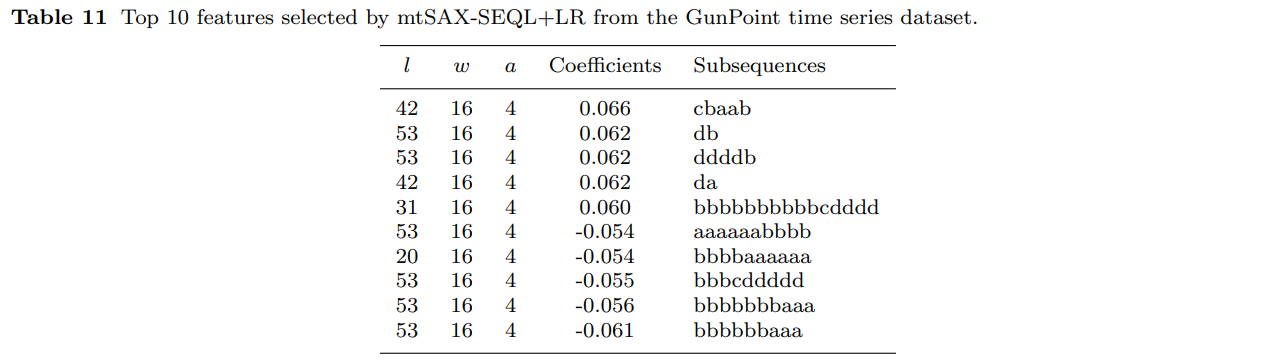

### Plot the interpretation curves

Inspired from https://github.com/lnthach/Mr-SEQL/blob/master/src/python/visual_timeseries.py

In [290]:
def compute_log_color(x):
	return (1.0/(1.0 + np.exp(-100*x)) - 0.5)*2

def compute_linewidth(x):
	return 1.0 + 4.0*x

def plot_thickness(ts,metats, ax=None):
	maxw = max(metats)
	# normalize the scores
	if maxw > 0:
		metats = metats / maxw
	lwa = np.array([compute_linewidth(x) for x in metats])
	# maxc = max(metats)
	# minc = min(metats)
	colormap = np.array([compute_log_color(x) for x in metats])

	for i in range(0,len(ts)-1):
		lw = (lwa[i] + lwa[i+1])/2
		color = (colormap[i]+colormap[i+1])/2
		if ax is None:
			plt.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[color,0,max(0,0.8 - color)])
		else:
			ax.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[color,0,max(0,0.8 - color)])

In [279]:
def get_weighted_ts(timeseries, label):
    """
    Adapted from `map_patterns` in https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/sax_converter.h

    Given a timeseries and its label, compute the contribution of each of its points.
    It is done "by hand".
    """     
    SAX_repr = dict()
    for l in list_l:
        list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=False)
        SAX_repr[l] = list_word

    list_begin_ROI = []
    list_end_ROI = []
    list_coeffs = []

    for id_coeff in range(len(coeffs)):
        coeff = coeffs[id_coeff]
        num_l, num_seq = find_l(thresholds, id_coeff)
        SOI = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
        lOI = list_l[num_l] # l of interest

        nb_occurrences = 0
        nb_locations = 0
        for cur_pos, word in enumerate(SAX_repr[lOI]):
            pos = 0
            while pos < w:
                pos = word.find(SOI, pos)
                if pos == -1:
                    break

                else:
                    begin_ROI = cur_pos + pos * lOI / w
                    end_ROI = begin_ROI + len(SOI) * lOI / w

                    begin_ROI = int(np.ceil(begin_ROI))
                    end_ROI = int(np.floor(end_ROI))

                    if begin_ROI>0:
                        begin_ROI -= 1

                    if end_ROI < L:
                        end_ROI += 1

                    list_begin_ROI.append(begin_ROI)
                    list_end_ROI.append(end_ROI)
                    nb_occurrences += 1
                    nb_locations += end_ROI-begin_ROI
                pos += 1

        for _ in range(nb_occurrences):
            list_coeffs.append(coeff/nb_locations)
                
    weighted_ts = np.zeros_like(timeseries)
    for begin_ROI, end_ROI, coeff in zip(list_begin_ROI, list_end_ROI, list_coeffs):
        weighted_ts[begin_ROI:end_ROI] += coeff
    
    if label == "1" :
        weighted_ts = - weighted_ts
    
    return weighted_ts

In [280]:
def get_paper_weighted_ts(timeseries, label):
    """
    Given a timeseries and its label, compute the contribution of each of its points.
    It is done directly using clf function.
    """
    weighted_ts = clf.map_sax_model(timeseries)[0]
    if label == "1":
        weighted_ts = -weighted_ts
    return weighted_ts

Here we have a problem, even when following the c++ code to reimplement it in Python, we still have minor changes in the results

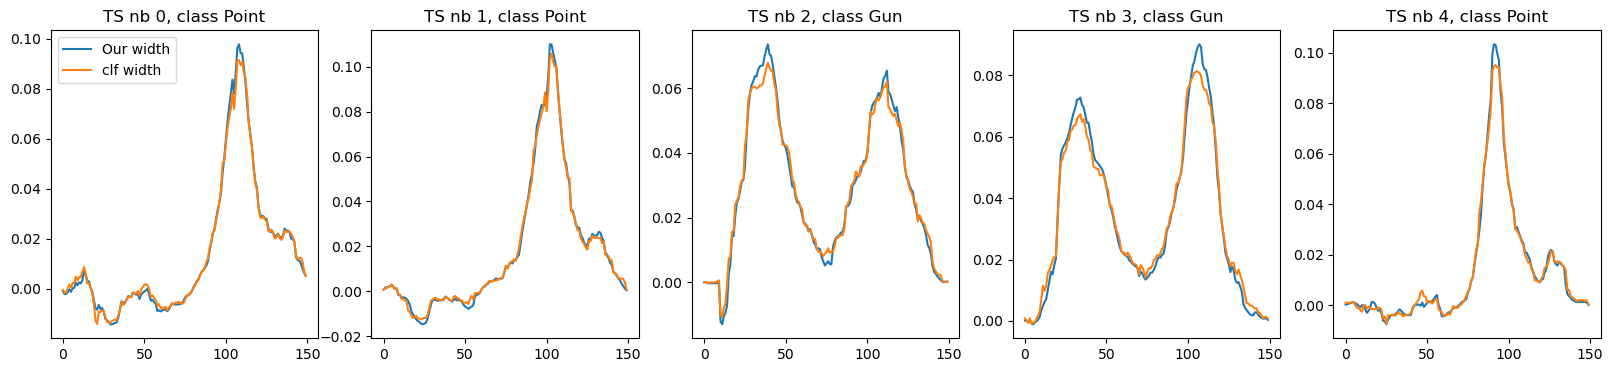

In [289]:
fig, ax = plt.subplots(1,5, figsize = (20,4))
for num_data in range(5):
    timeseries = X_train["dim_0"][num_data].to_numpy()
    label = y_train[num_data]
    weighted_ts = get_weighted_ts(timeseries, label)
    paper_weighted_ts = get_paper_weighted_ts(timeseries, label)
    ax[num_data].plot(weighted_ts, label="Our width")
    ax[num_data].plot(paper_weighted_ts, label="clf width")
    ax[num_data].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
ax[0].legend()
plt.show()

However, when plotting the interpretation curves, one can't really see the difference (unless a little on the left of TS nb 4).

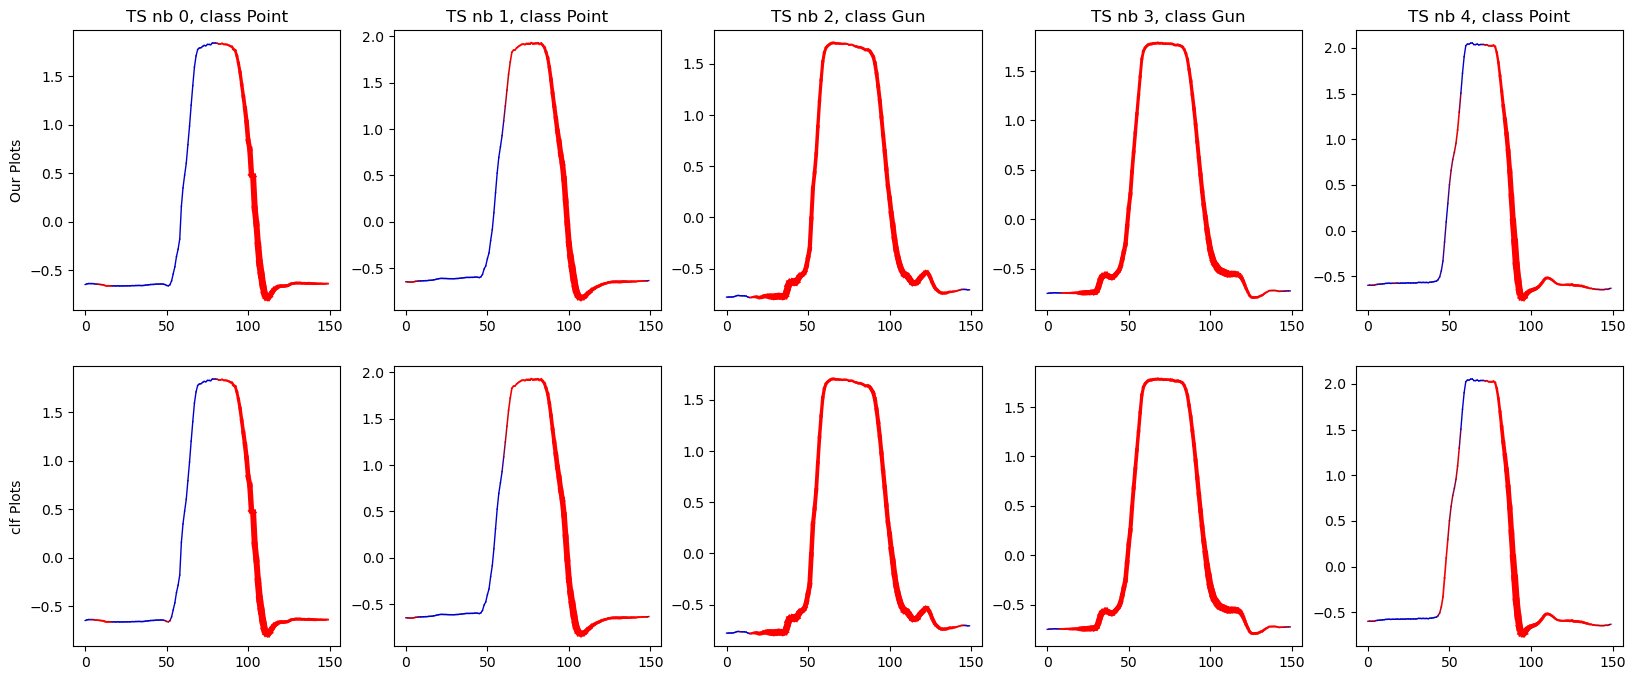

In [302]:
fig, ax = plt.subplots(2,5, figsize = (20,8))
for num_data in range(5):
    timeseries = X_train["dim_0"][num_data].to_numpy()
    label = y_train[num_data]
    weighted_ts = get_weighted_ts(timeseries, label)
    paper_weighted_ts = get_paper_weighted_ts(timeseries, label)

    plot_thickness(timeseries, np.maximum(weighted_ts, 0), ax=ax[0][num_data])
    plot_thickness(timeseries, np.maximum(paper_weighted_ts, 0), ax=ax[1][num_data])
    ax[0][num_data].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
    
ax[0][0].set_ylabel("Our Plots")
ax[1][0].set_ylabel("clf Plots")
plt.show()

One can see that for Point example, the right hollow is pointed out, but for the Gun point the left and right bump are more thickened than the rest of the TS (even if almost all of it is in red).

We can also compare them with the two examples given in the paper, and one can observe that we have pretty close curves (even if we had not the same best coefficient).

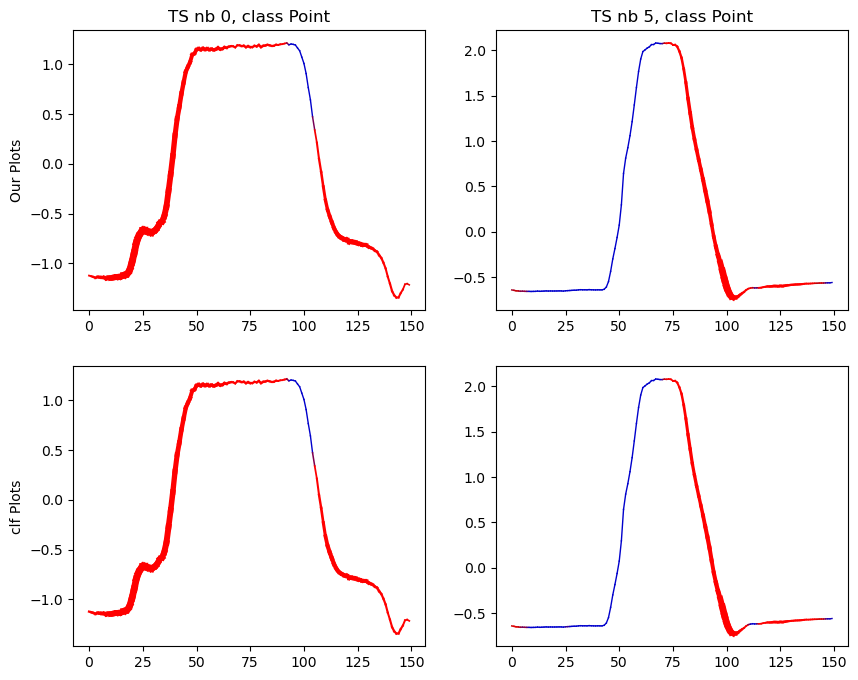

In [321]:
fig, ax = plt.subplots(2,2, figsize = (10,8))
for num_plot, num_data in enumerate([0,5]):
    timeseries = X_test["dim_0"][num_data].to_numpy()
    label = y_test[num_data]
    weighted_ts = get_weighted_ts(timeseries, label)
    paper_weighted_ts = get_paper_weighted_ts(timeseries, label)

    plot_thickness(timeseries, np.maximum(weighted_ts, 0), ax=ax[0][num_plot])
    plot_thickness(timeseries, np.maximum(paper_weighted_ts, 0), ax=ax[1][num_plot])
    ax[0][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
    
ax[0][0].set_ylabel("Our Plots")
ax[1][0].set_ylabel("clf Plots")
plt.show()

To be compare with

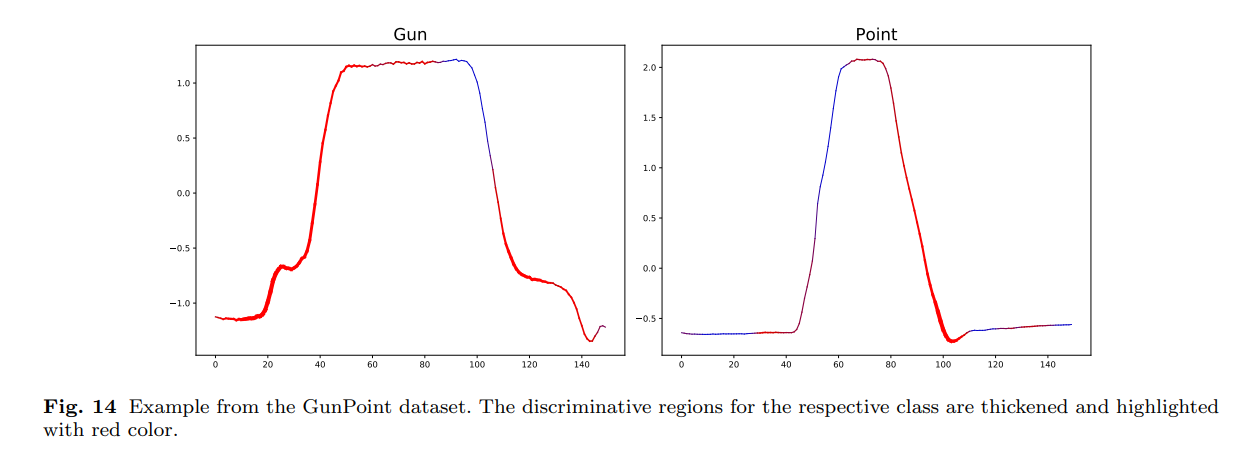